In [2]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
import time

In [15]:
M=1000
ite=10
dim_n=3
T=1
delta = torch.tensor(T/(ite))
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=0.5
rho=5
alpa=0.8
X0=10000
neuron_model_psi=20

In [4]:
print(delta)

tensor(0.1000)


In [12]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [13]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(X0*0.9,X0*1.1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
# print(x)
# print(x.shape)

In [5]:
def update(x3,psi):
  t=(x3[:,0]+delta)
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  #D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  D = (x3[:,1]+delta*kappa*torch.pow(torch.abs(psi),alpa))*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(D)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(torch.abs(psi),alpa+1))
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [16]:
start=time.time()
lr1 = 8e-3
epoch=0
num_epochs=8000
loss_epoch=[]
L_=torch.tensor([-1000])
optimizer = optim.Adam(model.parameters(), lr1)
cost=torch.tensor([100000])
err=1e-10
#print(psi.shape)
while (torch.abs(L_-cost)/torch.abs(L_)>err) &  (epoch <= num_epochs):
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  loss_epoch.append(cost)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  #print(cost,L_.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
  if (torch.abs(L_-cost)/torch.abs(L_)<=err):
    print("Delta Loss = {} , epoch = {}".format(torch.abs(L_-cost)/torch.abs(L_),epoch))
  epoch=epoch+1

end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean cost is 1895758.875.
At epoch 100 the mean cost is 97984.3125.
Delta Loss = 0.0 , epoch = 109
time elapsed= 0.9095680713653564


In [16]:
model= torch.load('model_N10_alpa0.8.pth')

# Cost

In [7]:
def closed_cost(y):
    cost1=0.0
    D1=0.0
    for i in range(ite+1):
        cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],alpa)
        D1=(D1+kappa*np.power(y[i],alpa))*np.exp(-rho*T/ite)
    return cost1

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the solution from python convex optimization package cvxpy

In [17]:
from torch.nn.modules.pooling import MaxPool1d
M1=20
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    #print(x_test)
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
# c_true=np.zeros(M1)
# c_pred=np.zeros(M1)
# c_num=np.zeros(M1)
# n_soln=np.zeros((M1,ite+1))
# t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
#   pred_cost=cost(a[i,:])
#   print('predicted cost=',pred_cost.detach().numpy(),'\n')
#   c_pred[i]=pred_cost

size of total order= 9500.0
predicted soln= tensor([2401.9204, 1700.7437, 1236.4230,  919.1085,  695.9358,  534.6136,
         415.2857,  324.8706,  256.3876,  204.5227,  810.1885]) sum of all execution= tensor(9500.)
size of total order= 9552.632
predicted soln= tensor([2415.2344, 1710.2717, 1243.3851,  924.2835,  699.8392,  537.5923,
         417.5800,  326.6594,  257.7536,  205.6000,  814.4326]) sum of all execution= tensor(9552.6318)
size of total order= 9605.263
predicted soln= tensor([2428.5479, 1719.8002, 1250.3480,  929.4590,  703.7425,  540.5712,
         419.8742,  328.4480,  259.1194,  206.6771,  818.6748]) sum of all execution= tensor(9605.2627)
size of total order= 9657.895
predicted soln= tensor([2441.8613, 1729.3292, 1257.3116,  934.6350,  707.6464,  543.5502,
         422.1687,  330.2367,  260.4851,  207.7541,  822.9170]) sum of all execution= tensor(9657.8945)
size of total order= 9710.526
predicted soln= tensor([2455.1755, 1738.8586, 1264.2754,  939.8111,  711.5507,  

Comparing the cost

Comparing solution for diffeternt testing samples

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


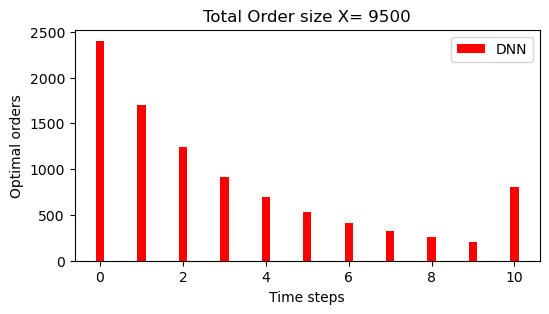

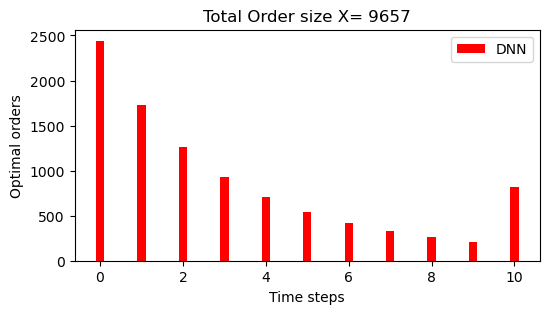

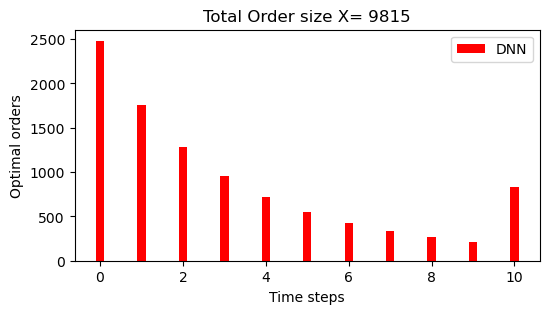

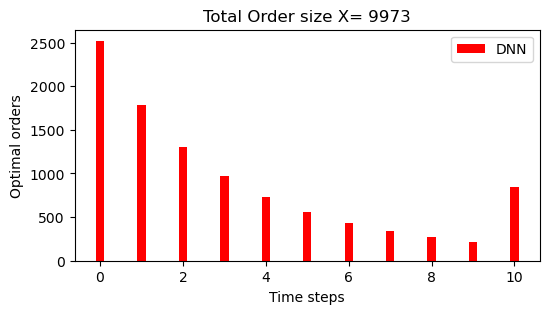

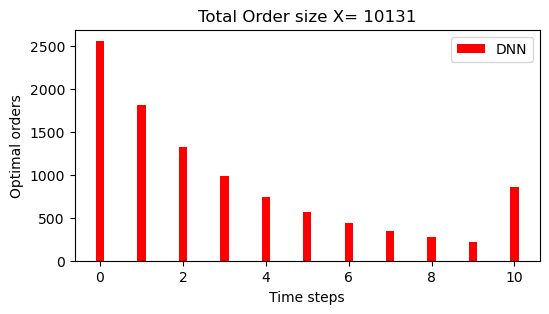

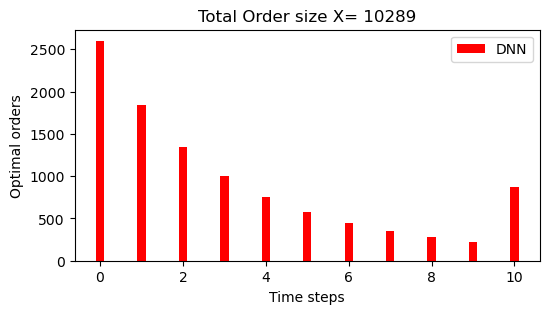

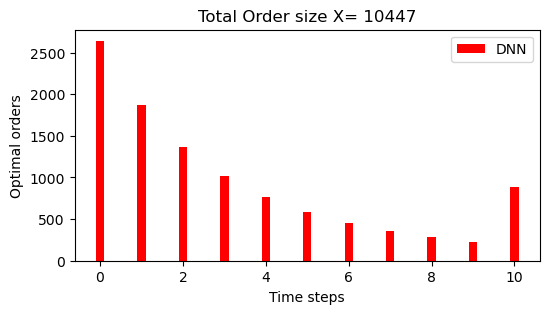

In [18]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
name='/Users/shirinprovat/Desktop/Robin_Research/LOB-Non-Lin/N_10_Alpa_0.8.eps'
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  #plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed-Form')
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='DNN')
  #plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numeric')
  plt.title('Total Order size X= %i' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()
  #plt.savefig('f.eps', format='eps')
  if(t==0):
    plt.savefig(name,format='eps')      
  plt.show()
for i in range(0,M1,3):
  plotting(i)



Comparing solution at different time steps

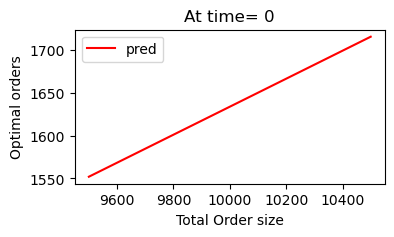

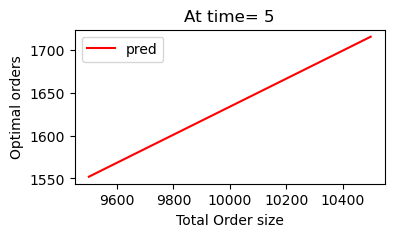

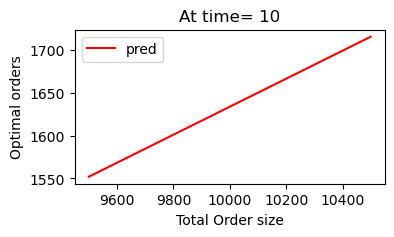

In [11]:
#p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
X=R_test.squeeze(1).numpy()
def plotting_time(t):
  #print(t_soln[t],p_soln[t])
  plt.figure(figsize=(4,2))
  plt.plot(X,p_soln[:,0],color='red',label='pred')
  plt.title('At time= %d' % (t_step[t]))
  plt.xlabel('Total Order size')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show
for i in range(0,t_step.shape[0],5):
  plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

# Saving Model

In [21]:
#torch.save(model, 'model_N10_alpa0.5.pth')